In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def count_decays(df):
    decay_count = (df.iloc[:,0] < 40000).sum()
    return decay_count

def plot_decay_times_histogram(df,bins=50):
    decay_times = df["tick"][df["tick"] < 40000]

    # Compute the histogram using np.histogram()
    hist, bin_edges = np.histogram(decay_times, bins=bins)

    # Plot the histogram
    plt.figure(figsize=(6, 4))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
    plt.xlabel('Decay Time [ns]')
    plt.ylabel('Frequency')
    plt.title('Histogram of Decay Times')
    plt.grid(True)
    plt.show()
    
data_dir = "data"
dataframes = []

for filename in os.listdir(data_dir):
    if filename.endswith(".data"):
        df = pd.read_csv(os.path.join(data_dir, filename), header=None, names=["tick","timestamp"], sep=" ")
        dataframes.append(df)
        df["timestamp"] = df["timestamp"] - df["timestamp"].iloc[0]
        
optimal_df = dataframes[0]
lower_df = dataframes[1]
higher_df = dataframes[2]
long_df = dataframes[3]

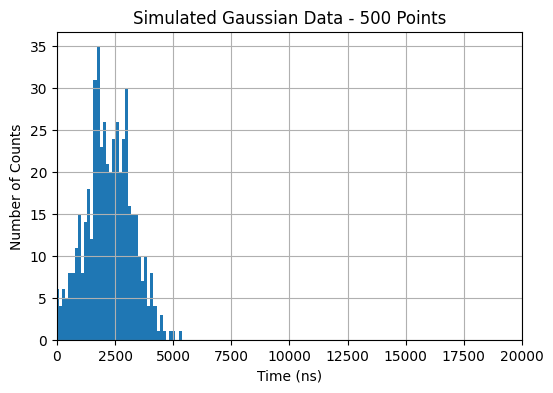

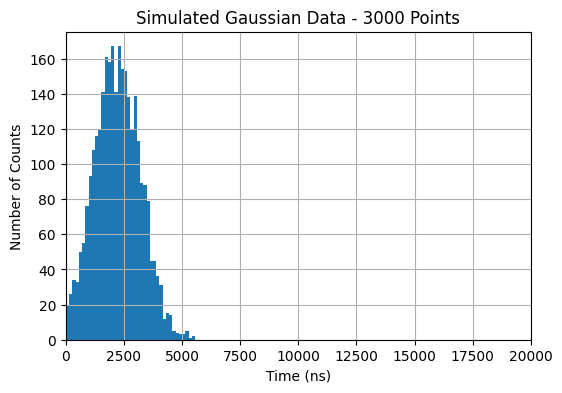

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def simulate_gaussian_cdf(mu, sigma, num_points=1000):
    # Generate equally spaced x values
    x_values = np.linspace(mu - 4 * sigma, mu + 4 * sigma, num_points)
    
    # Calculate the CDF values for the corresponding x values
    cdf_values = norm.cdf(x_values, mu, sigma)
    
    return x_values, cdf_values

def simulate_gaussian_data_from_cdf(cdf_values, x_values, num_points=1000):
    # Generate random probabilities
    probs = np.random.rand(num_points)
    
    # Interpolate the inverse CDF function
    inv_cdf_func = np.interp(probs, cdf_values, x_values)
    
    return inv_cdf_func

# True mean and standard deviation for muon decay scenario
true_mean = 2200  # ns
true_sigma = 1000   # ns

# Simulate the CDF for the Gaussian distribution
x_values, cdf_values = simulate_gaussian_cdf(true_mean, true_sigma)

# Number of data points to simulate
simulated_counts = [500, 3000]

# Simulate data points using inverse transform sampling
for count in simulated_counts:
    simulated_data = simulate_gaussian_data_from_cdf(cdf_values, x_values, num_points=count)
    plt.figure(figsize=(6, 4))
    plt.hist(simulated_data, bins=50)
    plt.xlabel('Time (ns)')
    plt.ylabel('Number of Counts')
    plt.title(f'Simulated Gaussian Data - {count} Points')
    plt.xlim(0,20000)
    plt.grid(True)
    plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

def gaussian_pdf(x, mu, sigma):
    """Calculate the Gaussian probability density function."""
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def neg_log_likelihood_binned(params, x, counts):
    """Negative log-likelihood function for binned ML method."""
    mu, sigma = params
    pdf_values = gaussian_pdf(x[:-1], mu, sigma)  # Calculate PDF values for bin centers
    pdf_values /= np.sum(pdf_values) * x  # Normalize PDF values to sum up to 1
    log_likelihood = np.sum(counts * np.log(pdf_values))
    return -log_likelihood

def least_squares(params, x, counts):
    """Least squares function."""
    mu, sigma = params
    pdf_values = gaussian_pdf(x[:-1], mu, sigma)  # Calculate PDF values for bin centers
    return np.sum((counts - pdf_values)**2)

def fit_gaussian_to_data(simulated_data, true_mean, true_sigma, num_points_fit=500):
    """Fit a Gaussian distribution to simulated data using both binned ML method and least squares."""
    # Simulate the CDF for the Gaussian distribution
    x_values = np.linspace(true_mean - 4 * true_sigma, true_mean + 4 * true_sigma, num_points_fit)
    cdf_values = norm.cdf(x_values, true_mean, true_sigma)
    
    # Initial guess for fitting parameters
    initial_guess = [true_mean, true_sigma]

    # Binned ML 
    print(x_values)
    print(simulated_data[:num_points_fit])
    res_binned_ml = minimize(neg_log_likelihood_binned, initial_guess, args=(x_values, simulated_data[:num_points_fit]), method='Nelder-Mead')
    mu_binned_ml, sigma_binned_ml = res_binned_ml.x

    # Least squares method
    res_least_squares = minimize(least_squares, initial_guess, args=(x_values, simulated_data[:num_points_fit]), method='Nelder-Mead')
    mu_least_squares, sigma_least_squares = res_least_squares.x

    # Plot histogram of simulated data
    plt.figure(figsize=(6, 4))
    plt.hist(simulated_data[:num_points_fit], bins=50, alpha=0.7, density=True, label=f'Simulated Data ({num_points_fit} points)')

    # Plot true Gaussian distribution
    x_true = np.linspace(np.min(simulated_data[:num_points_fit]), np.max(simulated_data[:num_points_fit]), 1000)
    plt.plot(x_true, gaussian_pdf(x_true, true_mean, true_sigma), 'r-', label='True Gaussian')

    # Plot fitted Gaussian distribution using binned ML method
    plt.plot(x_true, gaussian_pdf(x_true, mu_binned_ml, sigma_binned_ml), 'g--', label=f'Fitted (Binned ML, {num_points_fit} points)')

    # Plot fitted Gaussian distribution using least squares method
    plt.plot(x_true, gaussian_pdf(x_true, mu_least_squares, sigma_least_squares), 'b--', label=f'Fitted (Least Squares, {num_points_fit} points)')

    plt.xlabel('Time (ns)')
    plt.ylabel('Probability Density')
    plt.title('Fitting Gaussian Distribution to Simulated Data')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Binned ML Method:")
    print(f"Estimated Mean: {mu_binned_ml}")
    print(f"Estimated Standard Deviation: {sigma_binned_ml}")

    print("\nLeast Squares Method:")
    print(f"Estimated Mean: {mu_least_squares}")
    print(f"Estimated Standard Deviation: {sigma_least_squares}")

    return mu_binned_ml, sigma_binned_ml, mu_least_squares, sigma_least_squares

# Example usage:
true_mean = 2200  # ns
true_sigma = 500   # ns
simulated_data = np.concatenate([simulate_gaussian_data_from_cdf(cdf_values, x_values, num_points=500),
                                 simulate_gaussian_data_from_cdf(cdf_values, x_values, num_points=3000)])

fit_gaussian_to_data(simulated_data, true_mean, true_sigma)


[ 200.          208.01603206  216.03206413  224.04809619  232.06412826
  240.08016032  248.09619238  256.11222445  264.12825651  272.14428858
  280.16032064  288.17635271  296.19238477  304.20841683  312.2244489
  320.24048096  328.25651303  336.27254509  344.28857715  352.30460922
  360.32064128  368.33667335  376.35270541  384.36873747  392.38476954
  400.4008016   408.41683367  416.43286573  424.4488978   432.46492986
  440.48096192  448.49699399  456.51302605  464.52905812  472.54509018
  480.56112224  488.57715431  496.59318637  504.60921844  512.6252505
  520.64128257  528.65731463  536.67334669  544.68937876  552.70541082
  560.72144289  568.73747495  576.75350701  584.76953908  592.78557114
  600.80160321  608.81763527  616.83366733  624.8496994   632.86573146
  640.88176353  648.89779559  656.91382766  664.92985972  672.94589178
  680.96192385  688.97795591  696.99398798  705.01002004  713.0260521
  721.04208417  729.05811623  737.0741483   745.09018036  753.10621242
  761.122

ValueError: operands could not be broadcast together with shapes (499,) (500,) (499,) 

In [ ]:
print(f"Optimal: {count_decays(optimal_df)} muon decays in {optimal_df.iloc[-1,1]} seconds.")
print(f"Lower: {count_decays(lower_df)} muon decays in {lower_df.iloc[-1,1]} seconds.")
print(f"Higher: {count_decays(higher_df)} muon decays in {higher_df.iloc[-1,1]} seconds.")
print(f"Long Run: {count_decays(long_df)} muon decays in {long_df.iloc[-1,1]} seconds.")

Optimal: 23 muon decays in 786 seconds.
Lower: 21 muon decays in 159 seconds.
Higher: 20 muon decays in 834 seconds.
Long Run: 3296 muon decays in 178519 seconds.


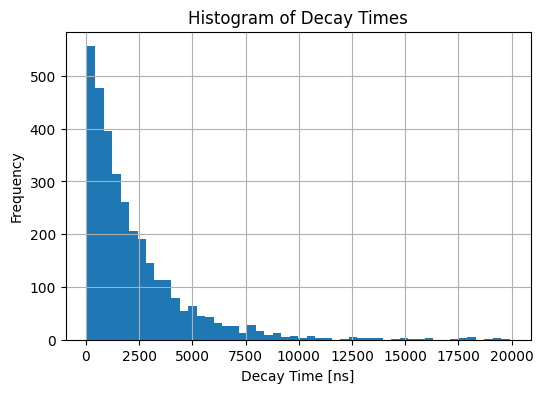

In [ ]:
plot_decay_times_histogram(long_df)